In [1]:
import re

In [2]:
!gcc -O3 -o wc just/examples/pipes/wc.c

In [ ]:
results = []
runs = 1000000
tests = {
    'c': './wc',
    'just-sync': 'just just/examples/pipes/wc.js',
    'just-async': 'just just/examples/pipes/wc-async.js',
    'node.js': 'node just/examples/pipes/wc-node.js',
    'node.js bindings': 'node just/examples/pipes/wc-node-fast.js'    
}
for name, command in tests.items():
    print(f'running {name}')
    result = !dd if=/dev/zero bs=65536 count={runs} | time -f "%U,%S,%M,%c,%w" {command} 1>/dev/null
    summary = re.search('(\d+) bytes.+copied,.([\d\.]+)', result[2])
    stats = result[3].split(',')
    result = {
        'name': name, 
        'total': int(summary.group(1)), 
        'time': float(summary.group(2)), 
        'user': float(stats[0]), 
        'system': float(stats[1]), 
        'rss': int(stats[2]), 
        'ix': int(stats[3]), 
        'vx': int(stats[4])
    }
    results.append(result)
print('tests complete')

running c
['1000000+0 records in', '1000000+0 records out', '65536000000 bytes (66 GB, 61 GiB) copied, 14.5241 s, 4.5 GB/s', '0.30,14.18,1596,200,2491']
running just-sync
['1000000+0 records in', '1000000+0 records out', '65536000000 bytes (66 GB, 61 GiB) copied, 14.832 s, 4.4 GB/s', '0.52,14.24,17844,107,5401']
running just-async
['1000000+0 records in', '1000000+0 records out', '65536000000 bytes (66 GB, 61 GiB) copied, 14.6984 s, 4.5 GB/s', '1.17,13.48,18192,95,3324']
running node.js
['1000000+0 records in', '1000000+0 records out', '65536000000 bytes (66 GB, 61 GiB) copied, 17.9388 s, 3.7 GB/s', '4.75,13.91,57048,60,28524']
running node.js bindings


In [138]:
from IPython.display import Code
Code(filename='wc.js')

const { net, sys, print, error } = just
const { read } = net
const { exit, strerror, errno, STDIN_FILENO } = sys
const BUFSIZE = 65536

const buf = new ArrayBuffer(BUFSIZE)
let size = 0
let n = 0
while ((n = read(STDIN_FILENO, buf))) size += n
if (n < 0) {
  error(`read: ${strerror(errno())} (${errno()})`)
  exit(1)
}
print(`size: ${size}`)

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[Text(0, 0, 'c'),
 Text(1, 0, 'just-sync'),
 Text(2, 0, 'just-async'),
 Text(3, 0, 'node.js'),
 Text(4, 0, 'node.js bindings')]

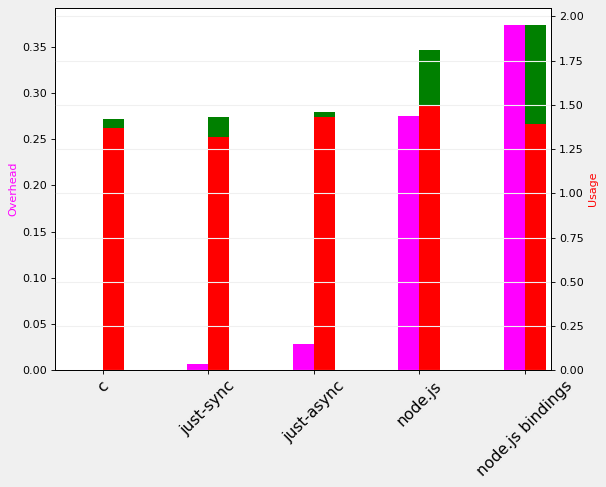

In [145]:
data = pd.DataFrame(results)
total = data['user'] + data['system']
data['total'] = total
fastest = min(data['total'])
overhead = (data['total'] - fastest) / fastest
data['overhead'] = overhead
df = data[['name','overhead','total','user','system']]
df = df.sort_values(['overhead', 'total'], ascending=[1,0])
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='#f0f0f0', edgecolor='k')
y1 = fig.add_subplot(111)
y2 = y1.twinx()
width = 0.2
df.system.plot(kind='bar', color='red', ax=y2, width=width, position=0)
df.user.plot(kind='bar', bottom=df.system, color='green', ax=y2, width=width, position=0)
df.overhead.plot(kind='bar', color='magenta', ax=y1, width=width, position=1)
plt.grid(color='#f0f0f0', linestyle='-', linewidth=1)
y1.set_ylabel('Overhead', color='magenta')
y2.set_ylabel('Usage', color='red')
y1.set_xticklabels(data['name'], rotation=45, fontsize=14)
